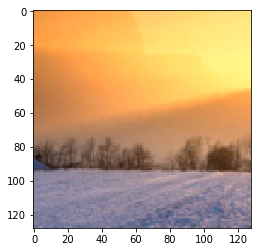

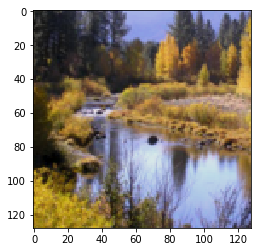

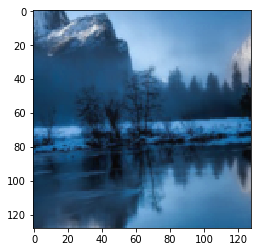

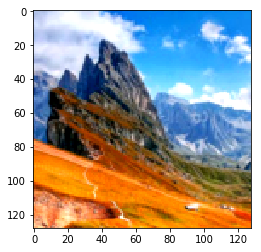

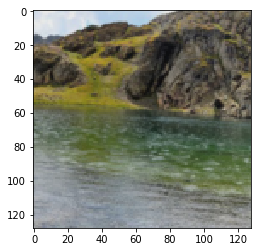

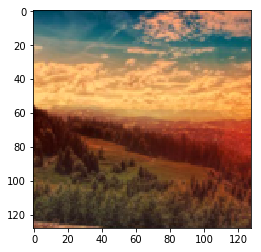

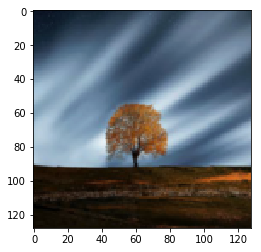

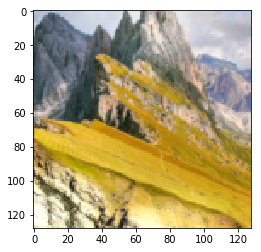

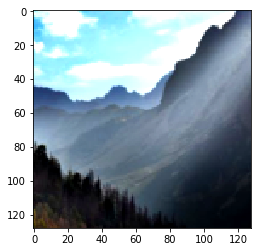

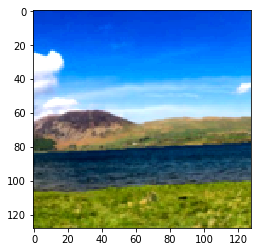

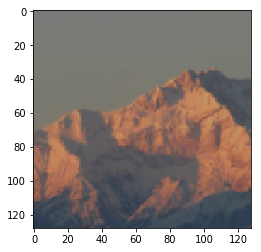

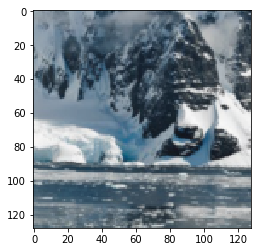

In [21]:
%matplotlib inline

import torch as th
import torchvision
import matplotlib.pyplot as plt
import Dataloader

# select the device to be used for training
device = th.device("cuda" if th.cuda.is_available() else "cpu")

transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(3),
    torchvision.transforms.RandomCrop((256, 256)), # TODO: Random scale too
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(.2, .2, .1, .01),
    torchvision.transforms.ToTensor(),
  ])

dataset = Dataloader.FlatDirectoryImageDataset('/Users/nicolas.dahlquist/datasets/pexels/landscapes', transform=transforms)

for i, d in enumerate(dataset):
    plt.imshow(d.permute(1, 2, 0).numpy())
    plt.show()
    if i > 10:
         break



In [22]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

vgg = models.vgg13_bn(pretrained=True).to(device)

# freeze all model parameters
vgg.eval()
for param in vgg.parameters():
    param.requires_grad = False
print(vgg.features)


def extract_features(x):
  # x = normalize(x)  # TODO
  #print(x.min(), x.max())
  
  # This is an approximation of the transform that the torchvision models want.
  x = (x - .5) * .6

  for i in range(12):
    x = vgg.features[i](x)
  return x

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNor

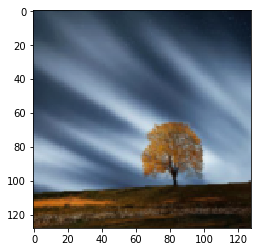

In [35]:
target = dataset[6]
plt.imshow(target.permute(1, 2, 0).numpy())
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.33150086


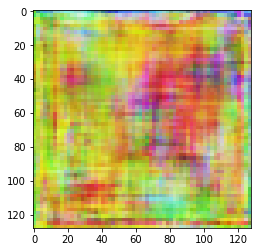

 10%|█         | 100/1000 [00:53<08:02,  1.87it/s]

0.029286979


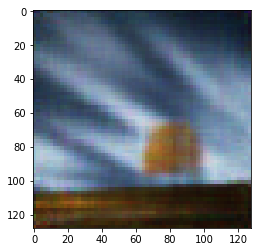

 20%|██        | 200/1000 [01:47<07:08,  1.87it/s]

0.021022463


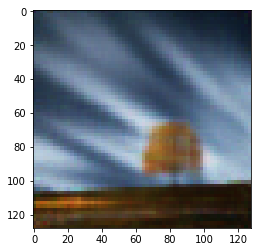

 30%|███       | 300/1000 [02:40<06:15,  1.87it/s]

0.01932387


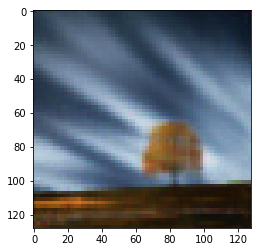

 40%|████      | 400/1000 [03:34<05:21,  1.87it/s]

0.017535444


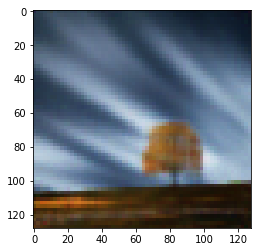

 50%|█████     | 500/1000 [04:28<04:28,  1.86it/s]

0.017425878


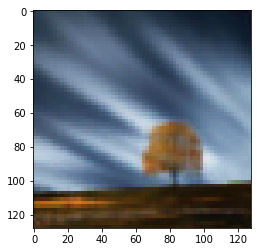

 60%|██████    | 600/1000 [05:22<03:34,  1.86it/s]

0.016868068


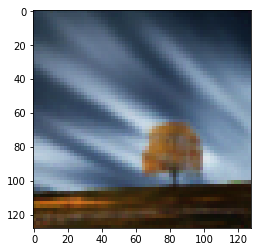

 70%|███████   | 700/1000 [06:16<02:41,  1.86it/s]

0.015980756


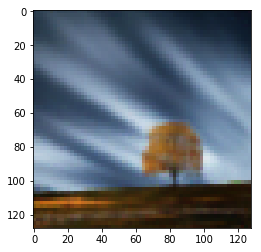

 80%|████████  | 800/1000 [07:10<01:47,  1.86it/s]

0.015807696


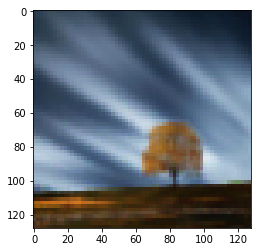

 90%|█████████ | 900/1000 [08:04<00:53,  1.86it/s]

0.015812617


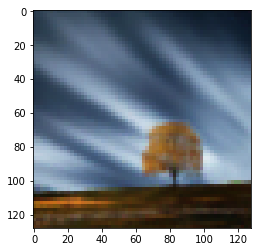

100%|██████████| 1000/1000 [08:58<00:00,  1.86it/s]


In [36]:
import PRO_GAN
import torch

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2

latent_size = 128

g = PRO_GAN.Generator(depth=7, latent_size=latent_size)

latent_vector = torch.randn(1, latent_size).to(device)

optimizer = torch.optim.Adam(g.parameters(), lr=.001)


for i in tqdm(range(1000)):
    
    generated = g(latent_vector, 5, 0)
    loss = torch.mean(torch.abs(target - generated[0]))
    perceptual_loss = torch.mean(torch.abs(extract_features(target.unsqueeze(0)) - extract_features(generated)))
    
    if i % 100 == 0:
        print(loss.detach().numpy())
        plt.imshow(generated[0].permute(1, 2, 0).detach().cpu().numpy())
        plt.show()
    cv2.imwrite('samples/%d.png' % i, (cv2.cvtColor(generated[0].permute(1, 2, 0).detach().cpu().numpy() * 255, cv2.COLOR_BGR2RGB)))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


